In [1]:
import pathlib
import yaml
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from analyze_pruning import collect_masks, compare_masks, eval_model
from experiment import MTLModel, MtlDataModule, prune_model

In [2]:
root_folder = pathlib.Path("/home/nik/phd/repo/disjoint_mtl/fashion_and_mnist/tmp/2022-11-09_11-42-45")

In [3]:
path_list = []

for child in root_folder.iterdir():
    if child.is_file() or child.name == ".submitit":
        continue
    
    path_list.append(child)

In [4]:
def hparams_from_dir(path):
    config_path = path / ".hydra" / "config.yaml"
    
    with config_path.open('r') as f:
        return yaml.safe_load(f)

def ckpts_from_dir(path):
    ckpts_files = [f for f in path.rglob("*.ckpt")]
    num_steps = [int(f.name.split("=")[-1].split(".")[0]) for f in ckpts_files]
    
    return [(s, f) for s, f in zip(num_steps, ckpts_files)]


In [5]:
df_as_dict_list = []

for path in path_list:
    cfg = hparams_from_dir(path)
    
    for steps, ckpt_path in ckpts_from_dir(path):
        tmp_dict = {}
        
        tmp_dict['lr'] = cfg['hparams']['max_lr']
        tmp_dict['model_seed'] = cfg['model_seed']
        tmp_dict['ckpt'] = ckpt_path
        tmp_dict['steps'] = steps
        tmp_dict['mode'] = cfg['hparams']['mode']
        
        df_as_dict_list.append(tmp_dict)

df = pd.DataFrame(df_as_dict_list)

In [6]:
df.head(3)

,lr,model_seed,ckpt,steps,mode
0,0.00001,123,/home/nik/phd/repo/disjoint_mtl/fashion_and_mn...,12500,fashion
1,0.00001,123,/home/nik/phd/repo/disjoint_mtl/fashion_and_mn...,2500,fashion
2,0.00001,123,/home/nik/phd/repo/disjoint_mtl/fashion_and_mn...,7500,fashion


In [7]:
# compute fashion 

In [8]:
data_folder = pathlib.Path("/home/nik/phd/repo/disjoint_mtl/data/logs/disjoint_mtl/fashion+mnist/")
dm_mnist = MtlDataModule(
    data_folder=data_folder,
    batch_size=256,
    mode="mnist",
)
dm_fashion = MtlDataModule(
    data_folder=data_folder,
    batch_size=256,
    mode="fashion",
)

In [18]:
def compute_prune_overlap(ckpt1, ckpt2, step=1):
    dc_list = []
    
    for i in tqdm(range(1, 101, step)):
        model1 = MTLModel.load_from_checkpoint(
            ckpt1,
            model="resnet18",
        ).cuda()
        model2 = MTLModel.load_from_checkpoint(
            ckpt2,
            model="resnet18",
        ).cuda()
        
        factor = i / 100
        prune_model(model1, factor)
        prune_model(model2, factor)
        
        overlap = compare_masks(model1, model2)
        dc_list.append({'prune_percentage': factor, 'overlap': overlap})
    
    return dc_list
    
        

In [19]:
df_n1 = df.loc[(df['lr'] == 0.00001) & (df['steps'].isin([20_000])) & (df['model_seed'] == 456)]

In [20]:
df_n1

,lr,model_seed,ckpt,steps,mode
52,0.00001,456,/home/nik/phd/repo/disjoint_mtl/fashion_and_mn...,20000,mnist
76,0.00001,456,/home/nik/phd/repo/disjoint_mtl/fashion_and_mn...,20000,fashion


In [21]:
df_n2 = df.loc[(df['lr'] == 0.00001) & (df['steps'].isin([20_000])) & (df['model_seed'] == 123)]

In [22]:
df_n2

,lr,model_seed,ckpt,steps,mode
4,0.00001,123,/home/nik/phd/repo/disjoint_mtl/fashion_and_mn...,20000,fashion
36,0.00001,123,/home/nik/phd/repo/disjoint_mtl/fashion_and_mn...,20000,mnist


In [23]:
models = []
models.append(("mnist_n1", df_n1.iloc[0].ckpt))
models.append(("mnist_n2", df_n2.iloc[0].ckpt))
models.append(("fashion_n1", df_n1.iloc[1].ckpt))
models.append(("fashion_n2", df_n2.iloc[1].ckpt))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

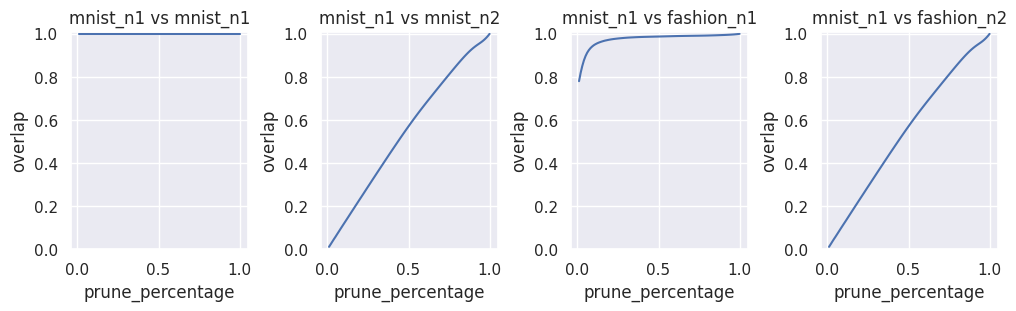

In [27]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(1, 4, figsize=(10, 3), constrained_layout=True)

for left_idx, (left_name, left_ckpt) in enumerate(models[0:1]):
    for right_idx, (right_name, right_ckpt) in enumerate(models):
        df_plot = pd.DataFrame(compute_prune_overlap(left_ckpt, right_ckpt, 1))
        sns.lineplot(data=df_plot, x='prune_percentage', y='overlap', ax=axes[right_idx]).set(
            ylim=[0, 1.01],
            title=f"{left_name} vs {right_name}"
        )      


In [28]:
fig.savefig('n1_vs_n2_lr_1e-5.png')

  0%|          | 0/100 [00:00<?, ?it/s]

[(0.0, 1.01), Text(0.5, 1.0, 'overlap random init')]

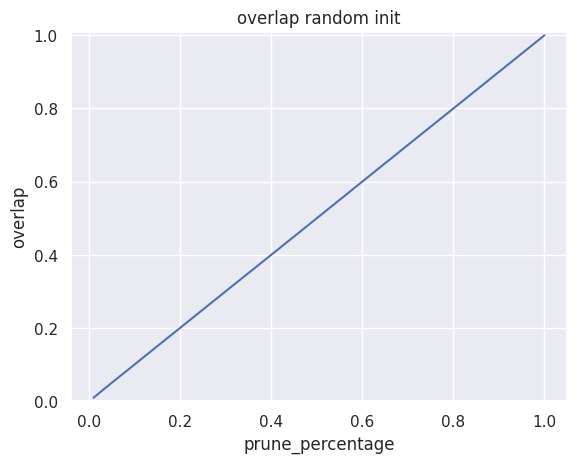

In [26]:
init_n2 = "/home/nik/phd/repo/disjoint_mtl/fashion_and_mnist/tmp/2022-11-09_11-42-45/initial_model_seed_123.ckpt"
init_n1 = "/home/nik/phd/repo/disjoint_mtl/fashion_and_mnist/tmp/2022-11-09_11-42-45/initial_model_seed_456.ckpt"

df_plot = pd.DataFrame(compute_prune_overlap(init_n1, init_n2, 1))
sns.set()

g = sns.lineplot(data=df_plot, x='prune_percentage', y='overlap').set(
    ylim=[0, 1.01],
    title=f"overlap random init"
)
plt.savefig("random_init_overlap.png")
g